************************************************************
************************* subj001 **************************
************************************************************
Loaded 88323 samples
Loaded 6 events
Extracted ranges for 6 events


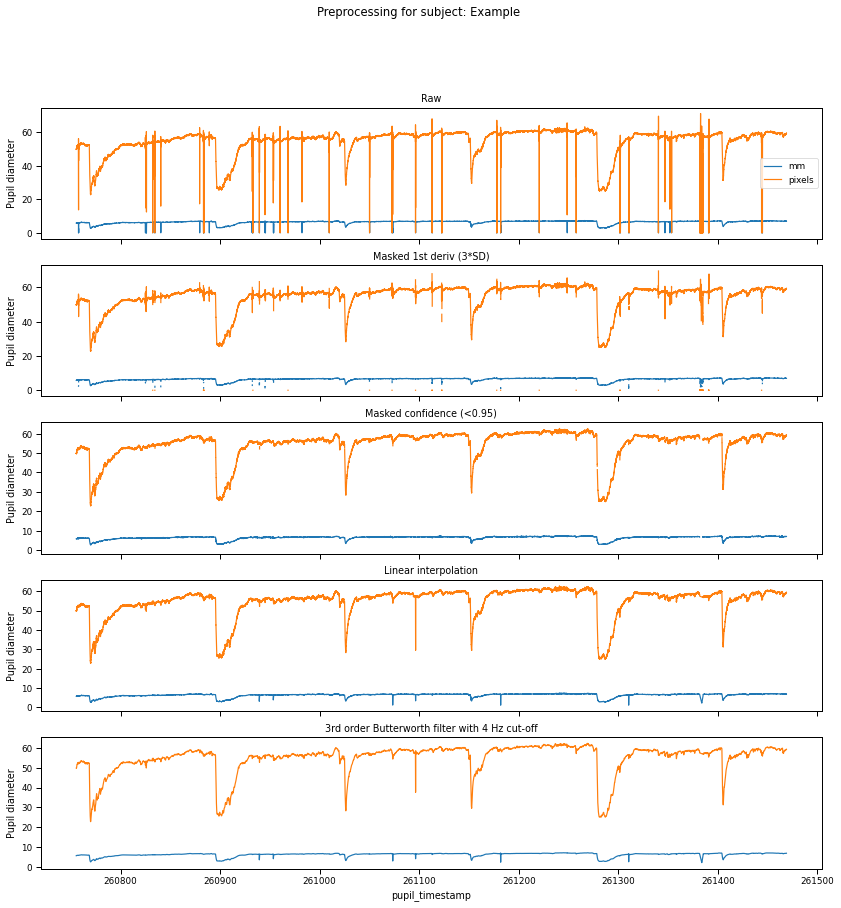

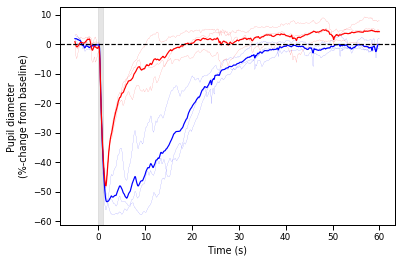

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')

from pyplr import graphing, utils, preproc
from pyplr.plr import PLR

# Some useful constants
SAMPLE_RATE = 120
DURATION = 7800
ONSET_IDX = 600
    
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Pupil Labs recording directory
rec_dirs = [r'C:\Users\engs2242\Documents\PyPlr\cvd_pupillometry\examples\PIPR\data\subj001']

for rec in rec_dirs:
    # Get a handle on a subject
    s = utils.new_subject(
        rec, export='000', out_dir_nm='pyplr_analysis')

    # Load pupil data
    samples = utils.load_pupil(
        s['data_dir'], eye_id='best', method='3d', cols=use_cols)
    
    # Pupil columns to analyse
    pupil_cols = ['diameter_3d', 'diameter']

    # Make figure for processing
    f, axs = graphing.pupil_preprocessing(nrows=5, subject='Example')

    # Plot the raw data
    samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
    axs[0].legend(loc='center right', labels=['mm', 'pixels'])

    # Mask first derivative
    samples = preproc.mask_pupil_first_derivative(
        samples, threshold=4.0, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

    # Mask confidence
    samples = preproc.mask_pupil_confidence(
        samples, threshold=0.98, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked confidence (<0.95)', ax=axs[2], legend=False)

    # Interpolate
    samples = preproc.interpolate_pupil(
        samples, interp_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Linear interpolation', ax=axs[3], legend=False)

     # Smooth  
    samples = preproc.butterworth_series(
        samples, fields=pupil_cols, filt_order=3, 
        cutoff_freq=4/(SAMPLE_RATE/2))
    samples[pupil_cols].plot(
        title='3rd order Butterworth filter with 4 Hz cut-off', 
        ax=axs[4], legend=False)
    
    # Load events
    events = utils.load_annotations(s['data_dir'])

    # Extract the event ranges
    ranges = utils.extract(
        samples, 
        events, 
        offset=-ONSET_IDX, 
        duration=DURATION, 
        borrow_attributes=['color'])
    
    # Calculate baselines
    baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

    # New columns for percent signal change
    ranges = preproc.percent_signal_change(
        ranges, baselines, pupil_cols)
    
    # Convert samples index-level to time (s)
    new_onset = (ranges.index.get_level_values('onset').unique() - ONSET_IDX) / SAMPLE_RATE
    ranges.index = ranges.index.set_levels(levels=new_onset, level='onset')
    
    # Plot PIPRs
    fig, ax = plt.subplots(figsize=(6,4))
    for r in range(6):
        c = ranges.loc[r, 'color'][0]
        ranges.loc[r, 'diameter_pc'].plot(color=c, lw='.1', ax=ax, legend=False)
        
    # Now show the means
    avgs = (ranges.reset_index()
             .groupby(['color','onset'], as_index=False)
             .mean())
    sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color', 
                 palette={'blue':'b','red':'r'}, legend=False)
    
    # Aesthetics
    ax.axvspan(0, 1, color='k', alpha=.1)
    ax.axhline(0, 0, 1, color='k', ls='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
    
    #average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
    #plr = PLR(average_plr, 
    #          sample_rate=SAMPLE_RATE, 
    #          onset_idx=ONSET_IDX, 
    #          stim_duration=1)
    #plr.plot()